In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib.animation import FuncAnimation

In [12]:
from scipy.signal import savgol_filter


def compute_spread_len(ds, h_factor=1.1):
    mask = ds.h > ds.attrs["hₛ"] * h_factor
    return mask.sum("x").isel(y=0) * ds.x.diff("x").median()


def compute_drop_velocity(ds, filter_winlen=51, filter_polyorder=3):
    c = ds.x[ds.h.argmax("x").isel(y=0)].diff("t")
    c = c.where((c > 0) & (c < 20)).dropna("t").interp(t=ds.t)
    c = xr.DataArray(
        data=savgol_filter(c, filter_winlen, filter_polyorder),
        coords=c.coords,
        dims=c.dims,
    )
    return c

In [13]:
from pathlib import Path

datasets = {}
for ds in sorted(Path("../data/outputs/reprojection/").glob("*.nc")):
    ds = xr.open_dataset(ds)
    ds["spread_len"] = compute_spread_len(ds)
    ds["drop_velocity"] = compute_drop_velocity(ds, filter_winlen=101)
    datasets[ds.attrs["reproject"]] = ds

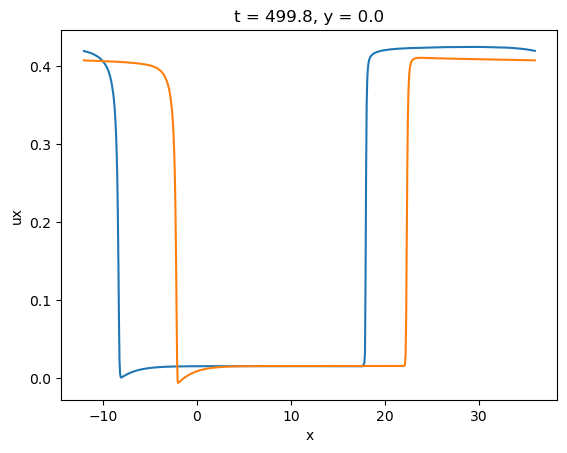

In [15]:
datasets[True].ux.isel(y=0).isel(t=-1).plot()
datasets[False].ux.isel(y=0).isel(t=-1).plot()

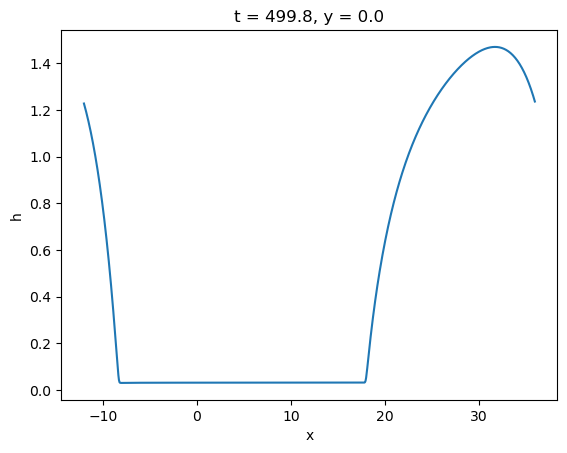

In [16]:
datasets[True].h.isel(t=-1).plot()

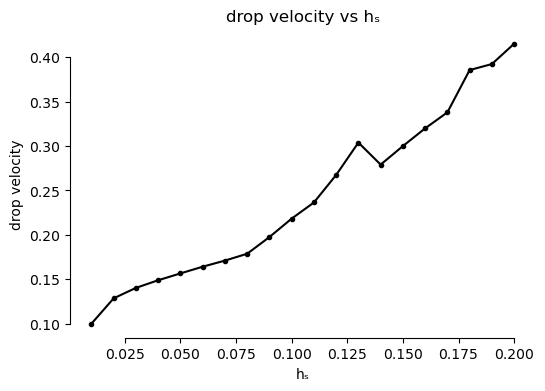

In [99]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    datasets.keys(),
    [ds.drop_velocity.isel(t=slice(-500)).mean() for hs, ds in datasets.items()],
    marker=".",
    color="k",
)
ax.set_xlabel("hₛ")
ax.set_ylabel("drop velocity")
ax.set_title("drop velocity vs hₛ")
sns.despine(trim=True)


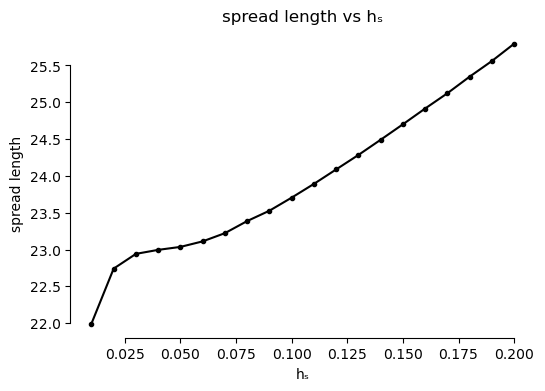

In [100]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    datasets.keys(),
    [ds.spread_len.isel(t=slice(-200)).mean() for hs, ds in datasets.items()],
    marker=".",
    color="k",
)
ax.set_xlabel("hₛ")
ax.set_ylabel("spread length")
ax.set_title("spread length vs hₛ")
sns.despine(trim=True)


In [18]:
for hs in datasets:
    ds = datasets[hs].sel(y=0)

    fig, ax = plt.subplots(figsize=(6, 4))

    frame = ds.h.sel(t=0.0)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    ax.plot(ds.x, frame, color="k")
    ax.set_title(f"t = {0.0:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("h")
    ymin, ymax = ax.get_ylim()
    sns.despine(trim=True)
    def animate(t):
        ax.clear()
        frame = ds.h.sel(t=t)
        frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
        ax.plot(ds.x, frame, color="k")
        ax.set_title(f"t = {t:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("h")
        ax.set_ylim(ymin, ymax)
        sns.despine(trim=True)
        return ax

    anim = FuncAnimation(fig, animate, frames=ds.t, interval=100)
    anim.save(f"movies/reproject={hs}.mp4", writer="ffmpeg", fps=24)

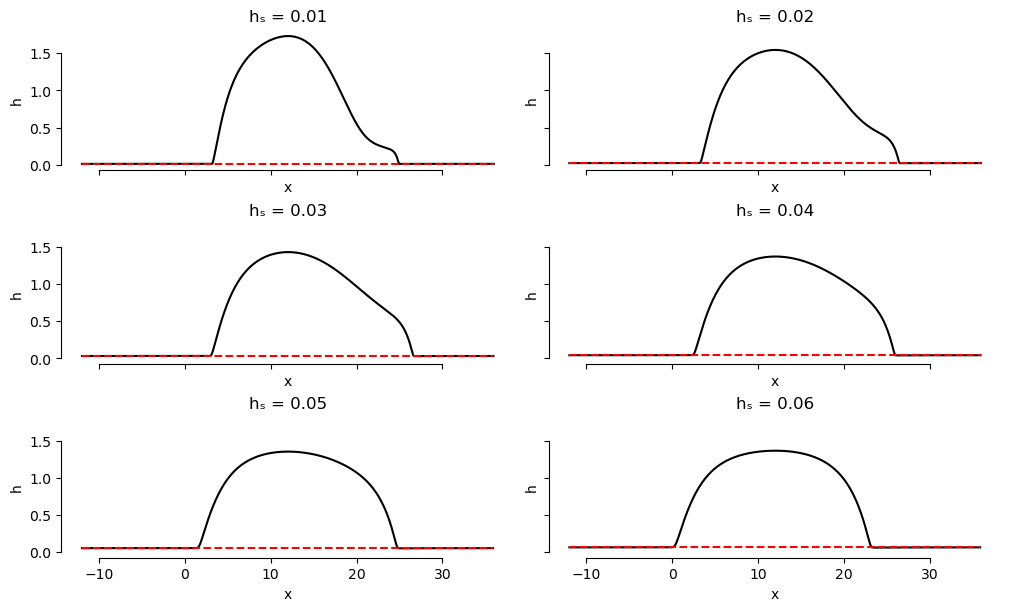

In [102]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True, constrained_layout=True)

for ds, ax in zip(datasets.values(), axs.flatten()):
    xmin, xmax = ds.x.min(), ds.x.max()
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    frame.plot(ax=ax, color="k")
    ax.hlines(ds.attrs["hₛ"] * 1.1, xmin, xmax, color="r", linestyle="--")
    ax.set_title(f"hₛ = {ds.attrs['hₛ']:.2f}")
    sns.despine(trim=True)

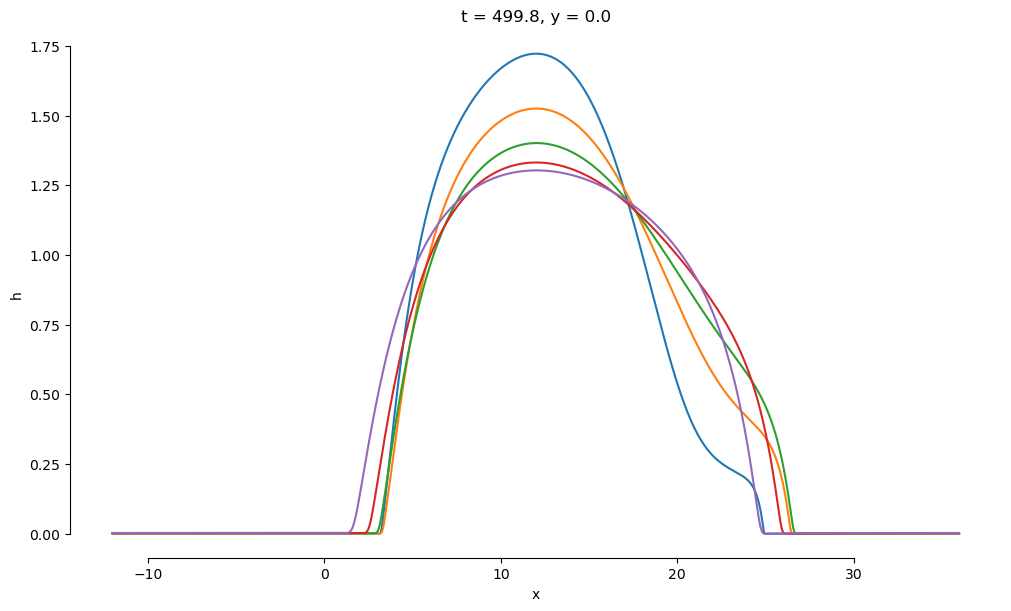

In [108]:
fig, ax = plt.subplots(figsize=(10, 6), sharex=True, sharey=True, constrained_layout=True)

for ds in list(datasets.values())[:5]:
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x"))) - ds.attrs["hₛ"]
    frame.plot(ax=ax)
    sns.despine(trim=True)